##Preprocessing

In [ ]:
pip install monai==1.2.0

In [ ]:
pip install dicom2nifti

In [ ]:
pip install first

In [ ]:
import os
import first
from glob import glob
import shutil
from tqdm import tqdm
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss
import torch

In [ ]:
def prepare(in_dir, pixdim=(1.0, 1.0, 1.0), a_min=1000, a_max=1500, spatial_size=[128,128,128], cache=False):

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSeg", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSeg", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),


        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [ ]:
in_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan'
patient = prepare(in_dir)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

##Training

In [ ]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def calculate_iou(predicted, target):
    iouvalue = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True, jaccard=True)
    iou_value = 1-iouvalue(predicted,target).item()
    return iou_value


In [ ]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import os

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1, device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    save_iou_train = []
    save_iou_test = []
    train_loader, test_loader = data_in

    # Initialize the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optim, mode='max', factor=0.1, patience=5, verbose=True)

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        epoch_iou_train = 0

        for batch_data in train_loader:
            train_step += 1
            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)

            train_loss = loss(outputs, label)

            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                  f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

            train_iou = calculate_iou(outputs, label)
            epoch_iou_train += train_iou
            print(f'Train_IoU: {train_iou:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')
        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        epoch_iou_train /= train_step
        print(f'Epoch_IoU: {epoch_iou_train:.4f}')
        save_iou_train.append(epoch_iou_train)
        np.save(os.path.join(model_dir, 'iou_train.npy'), save_iou_train)

        # Update the scheduler with the current epoch_metric_train
        scheduler.step(epoch_metric_train)

        if (epoch + 1) % test_interval == 0:
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0
                test_iou = 0
                epoch_iou_test = 0

                for test_data in test_loader:
                    test_step += 1
                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                    test_outputs = model(test_volume)

                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    test_iou = calculate_iou(test_outputs, test_label)
                    epoch_iou_test += test_iou

                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                epoch_iou_test /= test_step
                print(f'test_iou_epoch: {epoch_iou_test:.4f}')
                save_iou_test.append(epoch_iou_test)
                np.save(os.path.join(model_dir, 'iou_test.npy'), save_iou_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


In [ ]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
import einops

In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import annotations

import warnings
from collections.abc import Sequence

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, export

__all__ = ["UNet", "Unet"]

@export("monai.networks.nets")
@alias("Unet")
class UNet(nn.Module):
    """
    Enhanced version of UNet which has residual units implemented with the ResidualUnit class.
    The residual part uses a convolution to change the input dimensions to match the output dimensions
    if this is necessary but will use nn.Identity if not.
    Refer to: https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40.

    Each layer of the network has a encode and decode path with a skip connection between them. Data in the encode path
    is downsampled using strided convolutions (if `strides` is given values greater than 1) and in the decode path
    upsampled using strided transpose convolutions. These down or up sampling operations occur at the beginning of each
    block rather than afterwards as is typical in UNet implementations.

    To further explain this consider the first example network given below. This network has 3 layers with strides
    of 2 for each of the middle layers (the last layer is the bottom connection which does not down/up sample). Input
    data to this network is immediately reduced in the spatial dimensions by a factor of 2 by the first convolution of
    the residual unit defining the first layer of the encode part. The last layer of the decode part will upsample its
    input (data from the previous layer concatenated with data from the skip connection) in the first convolution. this
    ensures the final output of the network has the same shape as the input.

    Padding values for the convolutions are chosen to ensure output sizes are even divisors/multiples of the input
    sizes if the `strides` value for a layer is a factor of the input sizes. A typical case is to use `strides` values
    of 2 and inputs that are multiples of powers of 2. An input can thus be downsampled evenly however many times its
    dimensions can be divided by 2, so for the example network inputs would have to have dimensions that are multiples
    of 4. In the second example network given below the input to the bottom layer will have shape (1, 64, 15, 15) for
    an input of shape (1, 1, 240, 240) demonstrating the input being reduced in size spatially by 2**4.

    Args:
        spatial_dims: number of spatial dimensions.
        in_channels: number of input channels.
        out_channels: number of output channels.
        channels: sequence of channels. Top block first. The length of `channels` should be no less than 2.
        strides: sequence of convolution strides. The length of `stride` should equal to `len(channels) - 1`.
        kernel_size: convolution kernel size, the value(s) should be odd. If sequence,
            its length should equal to dimensions. Defaults to 3.
        up_kernel_size: upsampling convolution kernel size, the value(s) should be odd. If sequence,
            its length should equal to dimensions. Defaults to 3.
        num_res_units: number of residual units. Defaults to 0.
        act: activation type and arguments. Defaults to PReLU.
        norm: feature normalization type and arguments. Defaults to instance norm.
        dropout: dropout ratio. Defaults to no dropout.
        bias: whether to have a bias term in convolution blocks. Defaults to True.
            According to `Performance Tuning Guide <https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html>`_,
            if a conv layer is directly followed by a batch norm layer, bias should be False.
        adn_ordering: a string representing the ordering of activation (A), normalization (N), and dropout (D).
            Defaults to "NDA". See also: :py:class:`monai.networks.blocks.ADN`.

    Examples::

        from monai.networks.nets import UNet

        # 3 layer network with down/upsampling by a factor of 2 at each layer with 2-convolution residual units
        net = UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            channels=(4, 8, 16),
            strides=(2, 2),
            num_res_units=2
        )

        # 5 layer network with simple convolution/normalization/dropout/activation blocks defining the layers
        net=UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            channels=(4, 8, 16, 32, 64),
            strides=(2, 2, 2, 2),
        )

    Note: The acceptable spatial size of input data depends on the parameters of the network,
        to set appropriate spatial size, please check the tutorial for more details:
        https://github.com/Project-MONAI/tutorials/blob/master/modules/UNet_input_size_constrains.ipynb.
        Typically, when using a stride of 2 in down / up sampling, the output dimensions are either half of the
        input when downsampling, or twice when upsampling. In this case with N numbers of layers in the network,
        the inputs must have spatial dimensions that are all multiples of 2^N.
        Usually, applying `resize`, `pad` or `crop` transforms can help adjust the spatial size of input data.

    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Sequence[int] | int = 3,
        up_kernel_size: Sequence[int] | int = 3,
        num_res_units: int = 0,
        act: tuple | str = Act.PRELU,
        norm: tuple | str = Norm.INSTANCE,
        dropout: float = 0.0,
        bias: bool = True,
        adn_ordering: str = "NDA",
    ) -> None:
        super().__init__()

        if len(channels) < 2:
            raise ValueError("the length of `channels` should be no less than 2.")
        delta = len(strides) - (len(channels) - 1)
        if delta < 0:
            raise ValueError("the length of `strides` should equal to `len(channels) - 1`.")
        if delta > 0:
            warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
        if isinstance(kernel_size, Sequence) and len(kernel_size) != spatial_dims:
            raise ValueError("the length of `kernel_size` should equal to `dimensions`.")
        if isinstance(up_kernel_size, Sequence) and len(up_kernel_size) != spatial_dims:
            raise ValueError("the length of `up_kernel_size` should equal to `dimensions`.")

        self.dimensions = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout
        self.bias = bias
        self.adn_ordering = adn_ordering

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], is_top: bool
        ) -> nn.Module:
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.

            Args:
                inc: number of input channels.
                outc: number of output channels.
                channels: sequence of channels. Top block first.
                strides: convolution stride.
                is_top: True if this is the top block.
            """
            c = channels[0]
            s = strides[0]

            subblock: nn.Module

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], False)  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer
                subblock = self._get_bottom_layer(c, channels[1])
                upc = c + channels[1]

            down = self._get_down_layer(inc, c, s, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, is_top)  # create layer in upsampling path

            return self._get_connection_block(down, up, subblock)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, True)

    def _get_connection_block(self, down_path: nn.Module, up_path: nn.Module, subblock: nn.Module) -> nn.Module:
        """
        Returns the block object defining a layer of the UNet structure including the implementation of the skip
        between encoding (down) and decoding (up) sides of the network.

        Args:
            down_path: encoding half of the layer
            up_path: decoding half of the layer
            subblock: block defining the next layer in the network.
        Returns: block for this layer: `nn.Sequential(down_path, SkipConnection(subblock), up_path)`
        """
        return nn.Sequential(down_path, SkipConnection(subblock), up_path)

    def _get_down_layer(self, in_channels: int, out_channels: int, strides: int, is_top: bool) -> nn.Module:
        """
        Returns the encoding (down) part of a layer of the network. This typically will downsample data at some point
        in its structure. Its output is used as input to the next layer down and is concatenated with output from the
        next layer to form the input for the decode (up) part of the layer.

        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        mod: nn.Module
        if self.num_res_units > 0:
            mod = ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                bias=self.bias,
                adn_ordering=self.adn_ordering,
            )
            return mod
        mod = Convolution(
            self.dimensions,
            in_channels,
            out_channels,
            strides=strides,
            kernel_size=self.kernel_size,
            act=self.act,
            norm=self.norm,
            dropout=self.dropout,
            bias=self.bias,
            adn_ordering=self.adn_ordering,
        )
        return mod

    def _get_bottom_layer(self, in_channels: int, out_channels: int) -> nn.Module:
        """
        Returns the bottom or bottleneck layer at the bottom of the network linking encode to decode halves.

        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
        """
        return self._get_down_layer(in_channels, out_channels, 1, False)

    def _get_up_layer(self, in_channels: int, out_channels: int, strides: int, is_top: bool) -> nn.Module:
        """
        Returns the decoding (up) part of a layer of the network. This typically will upsample data at some point
        in its structure. Its output is used as input to the next layer up.

        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        conv: Convolution | nn.Sequential

        conv = Convolution(
            self.dimensions,
            in_channels,
            out_channels,
            strides=strides,
            kernel_size=self.up_kernel_size,
            act=self.act,
            norm=self.norm,
            dropout=self.dropout,
            bias=self.bias,
            conv_only=is_top and self.num_res_units == 0,
            is_transposed=True,
            adn_ordering=self.adn_ordering,
        )

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                bias=self.bias,
                last_conv_only=is_top,
                adn_ordering=self.adn_ordering,
            )
            conv = nn.Sequential(conv, ru)

        return conv

def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x

Unet = UNet

In [ ]:
from monai.networks.nets import UNet
from monai.losses import DiceFocalLoss

In [ ]:
data_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan'
model_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/leaky unet'
data_in = prepare(data_dir, cache=False)

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.BATCH,
    dropout=0.1,
    act='LEAKYRELU'
).to(device)


#loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
loss_function = DiceFocalLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


In [ ]:
train(model, data_in, loss_function, optimizer, 500, model_dir)

Streaming output truncated to the last 5000 lines.
Train_IoU: 0.9810
6/16, Train_loss: 0.0138
Train_dice: 0.9900
Train_IoU: 0.9803
7/16, Train_loss: 0.0149
Train_dice: 0.9896
Train_IoU: 0.9796
8/16, Train_loss: 0.0115
Train_dice: 0.9905
Train_IoU: 0.9813
9/16, Train_loss: 0.0122
Train_dice: 0.9898
Train_IoU: 0.9800
10/16, Train_loss: 0.0116
Train_dice: 0.9906
Train_IoU: 0.9814
11/16, Train_loss: 0.0141
Train_dice: 0.9896
Train_IoU: 0.9796
12/16, Train_loss: 0.0125
Train_dice: 0.9898
Train_IoU: 0.9800
13/16, Train_loss: 0.0118
Train_dice: 0.9898
Train_IoU: 0.9800
14/16, Train_loss: 0.0132
Train_dice: 0.9904
Train_IoU: 0.9810
15/16, Train_loss: 0.0136
Train_dice: 0.9901
Train_IoU: 0.9804
16/16, Train_loss: 0.0153
Train_dice: 0.9884
Train_IoU: 0.9773
--------------------
Epoch_loss: 0.0131
Epoch_metric: 0.9900
Epoch_IoU: 0.9803
test_loss_epoch: 0.0396
test_dice_epoch: 0.9745
test_iou_epoch: 0.9511
current epoch: 416 current mean dice: 0.9738
best mean dice: 0.9748 at epoch: 55
----------


##Testing

In [ ]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))
train_iou = np.load(os.path.join(model_dir, 'iou_train.npy'))
test_iou = np.load(os.path.join(model_dir, 'iou_test.npy'))

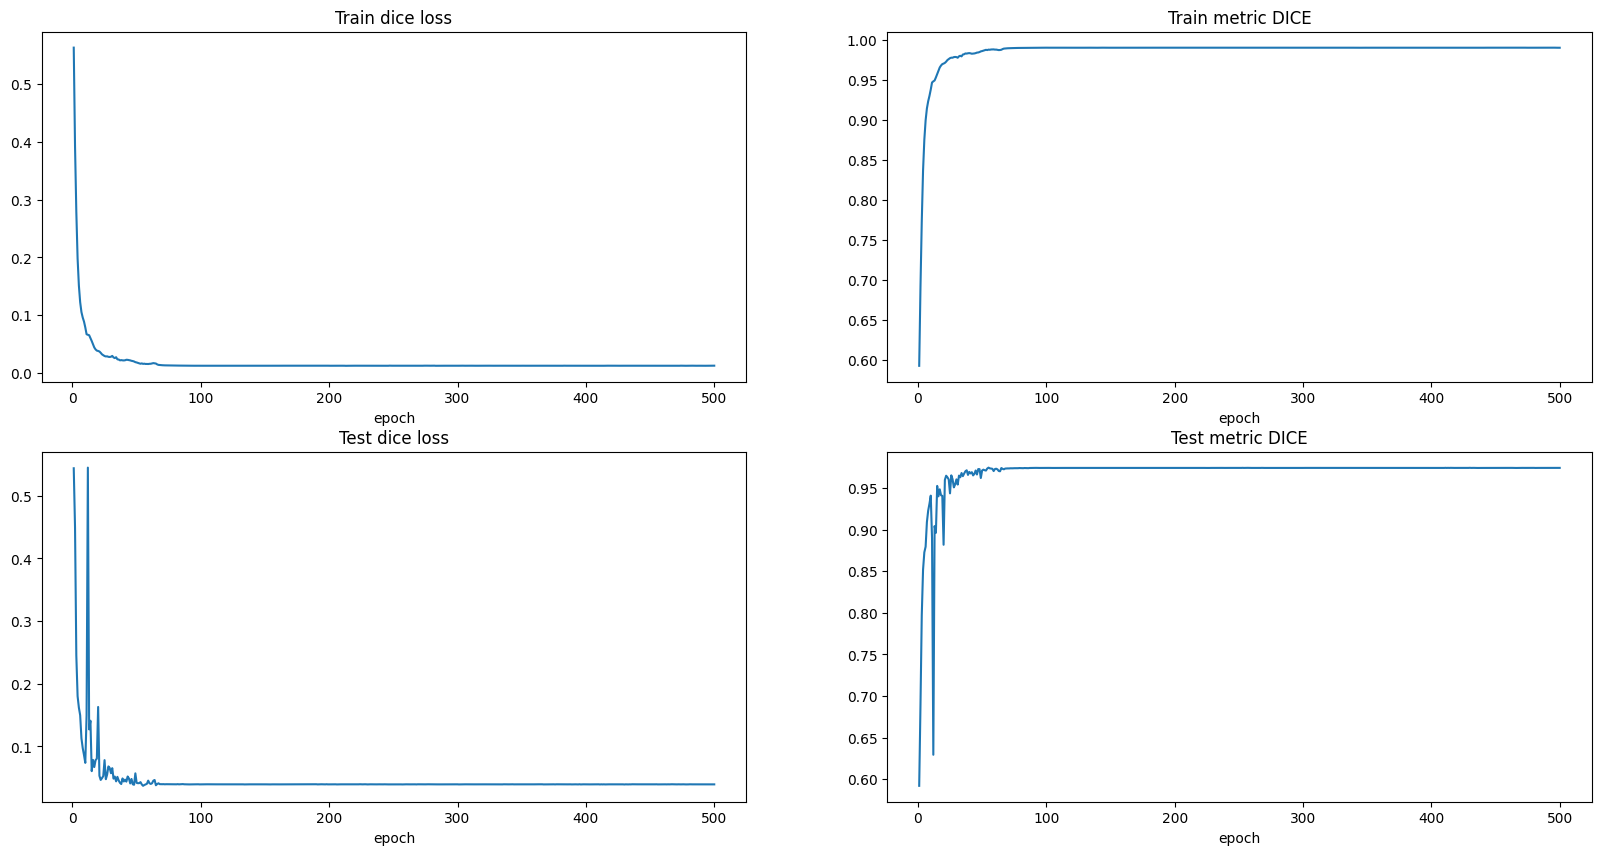

In [ ]:
plt.figure("Evaluate", (20, 10))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

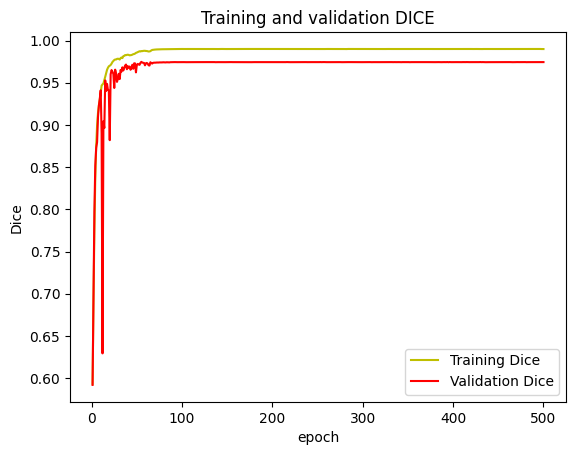

In [ ]:
# Plot training and validation dice
plt.title("Training and validation DICE")
dice = train_metric
val_dice = test_metric
epochs = [i + 1 for i in range(len(train_metric))]
plt.plot(epochs, dice, 'y', label='Training Dice')
plt.plot(epochs, val_dice, 'r', label='Validation Dice')
plt.xlabel("epoch")
plt.ylabel("Dice")
plt.legend()
plt.show()

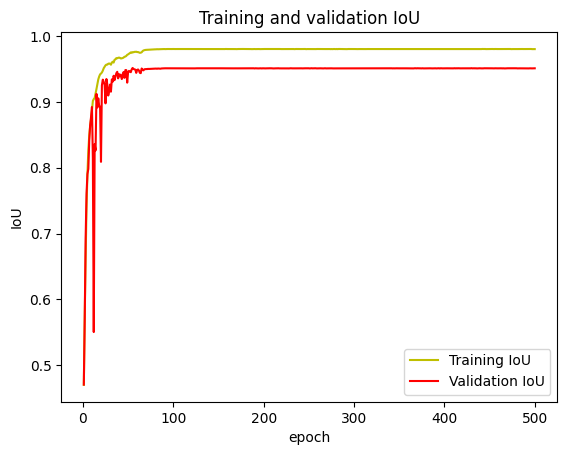

In [ ]:
# Plot training and validation IOU
plt.title("Training and validation IoU")
iou = train_iou
val_iou = test_iou
epochs = [i + 1 for i in range(len(train_iou))]
plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.xlabel("epoch")
plt.ylabel("IoU")
plt.legend()
plt.show()

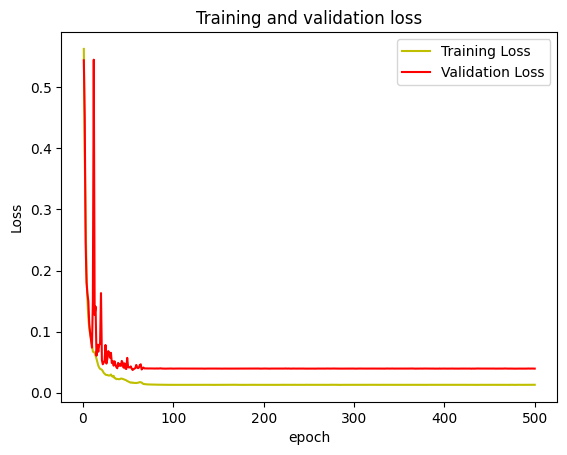

In [ ]:
# Plot training and validation loss
plt.title("Training and validation loss")
loss = train_loss
val_loss = test_loss
epochs = [i + 1 for i in range(len(train_loss))]
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
in_dir = data_dir
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSeg", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSeg", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[0:4]

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.0,1.0,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=1000, a_max=1500,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,128]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [ ]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [ ]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.BATCH,
    dropout=0.1,
    act='LEAKYRELU'
).to(device)

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.1, inplace=False)
        (A): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.1, inplace=False)
            (A): LeakyReLU(negative_slope=0.01)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): 

In [ ]:
pip install torchsummary

In [ ]:
from torchsummary import summary

# Print the model summary
summary(model, (1, 128, 128, 128), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 64, 64, 64]             448
       BatchNorm3d-2       [-1, 16, 64, 64, 64]              32
           Dropout-3       [-1, 16, 64, 64, 64]               0
         LeakyReLU-4       [-1, 16, 64, 64, 64]               0
            Conv3d-5       [-1, 32, 32, 32, 32]          13,856
       BatchNorm3d-6       [-1, 32, 32, 32, 32]              64
           Dropout-7       [-1, 32, 32, 32, 32]               0
         LeakyReLU-8       [-1, 32, 32, 32, 32]               0
            Conv3d-9       [-1, 64, 16, 16, 16]          55,360
      BatchNorm3d-10       [-1, 64, 16, 16, 16]             128
          Dropout-11       [-1, 64, 16, 16, 16]               0
        LeakyReLU-12       [-1, 64, 16, 16, 16]               0
           Conv3d-13         [-1, 128, 8, 8, 8]         221,312
      BatchNorm3d-14         [-1, 128, 

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary
# Create a dummy input with batch dimension
dummy_input = torch.randn(1, 1, 128, 128, 128).to(device)  # Adjust the size based on your actual input size

# Print the model summary
summary(model, input_size=dummy_input.shape, device=device)

Layer (type:depth-idx)                                                      Output Shape              Param #
UNet                                                                        [1, 2, 128, 128, 128]     --
├─Sequential: 1-1                                                           [1, 2, 128, 128, 128]     --
│    └─Convolution: 2-1                                                     [1, 16, 64, 64, 64]       --
│    │    └─Conv3d: 3-1                                                     [1, 16, 64, 64, 64]       448
│    │    └─ADN: 3-2                                                        [1, 16, 64, 64, 64]       32
│    └─SkipConnection: 2-2                                                  [1, 32, 64, 64, 64]       --
│    │    └─Sequential: 3-3                                                 [1, 16, 64, 64, 64]       1,978,608
│    └─Convolution: 2-3                                                     [1, 2, 128, 128, 128]     --
│    │    └─ConvTranspose3d: 3-4          

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.inferers import sliding_window_inference

In [ ]:
sw_batch_size = 4
roi_size = (128, 128, 128)
with torch.no_grad():
    test_patient = first(test_loader) #
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    for i in range(128):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"CT {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"Mask {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f"Prediction {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i], cmap='gray')
        plt.show()

In [ ]:
import torch
import time
import matplotlib.pyplot as plt
from monai.transforms import Activations
from monai.inferers import sliding_window_inference

# Assuming your model is already defined and loaded into the 'model' variable.
# Also, assuming 'test_loader' is your DataLoader.

sw_batch_size = 4
roi_size = (128, 128, 128)

# Get a sample from the test_loader
with torch.no_grad():
    test_patient = next(iter(test_loader))
    t_volume = test_patient['vol'].to(device)

    # Measure inference time
    start_time = time.time()

    # Inference
    test_outputs = sliding_window_inference(t_volume, roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    # Measure elapsed time
    elapsed_time = time.time() - start_time
    print(f"Inference time: {elapsed_time} seconds")

    # Visualization (assuming you have 'seg' in your test_patient)
    for i in range(128):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i], cmap='gray')
        plt.show()

In [ ]:
# Load the best model checkpoint
best_model_path = os.path.join(model_dir, "best_metric_model.pth")
best_model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.BATCH,
    dropout=0.1,
    act='LEAKYRELU'
).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

def evaluate(model, dataloader, loss_function, device=torch.device("cuda:0")):
    model.eval()
    total_loss = 0.0
    total_metric = 0.0
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch_data in dataloader:
            inputs = batch_data["vol"].to(device)
            labels = batch_data["seg"].to(device)
            labels = labels != 0  # Assuming binary segmentation

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            total_loss += loss.item()

            # Compute your evaluation metric (e.g., dice coefficient)
            metric = dice_metric(outputs, labels)
            total_metric += metric

            # Compute IoU
            iou = calculate_iou(outputs, labels)
            total_iou += iou

            total_samples += inputs.size(0)

    average_loss = total_loss / total_samples
    average_metric = total_metric / total_samples
    average_iou = total_iou / total_samples

    return average_loss, average_metric, average_iou

# Evaluate the best model on your test data
final_test_loss, final_test_metric, final_test_iou = evaluate(best_model, test_loader, loss_function, device)

# Print the final metrics
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Dice: {final_test_metric:.4f}")
print(f"Final Test IoU: {final_test_iou:.4f}")

Final Test Loss: 0.0373
Final Test Dice: 0.9748
Final Test IoU: 0.9516


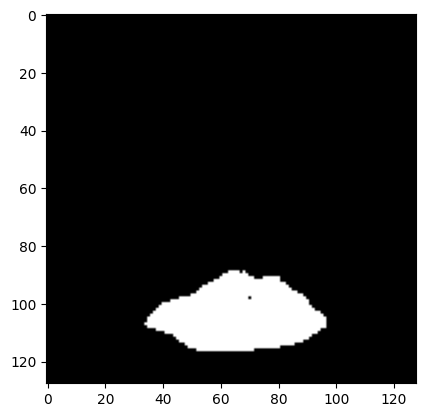

In [ ]:
import nibabel as nib
from torch.cuda.amp import autocast

sw_batch_size = 4
roi_size = (128, 128, 128)

with torch.no_grad(), autocast():
    test_patient = first(test_loader) #
    t_volume = test_patient['vol']
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    # Convert boolean array to integer array
    prediction_array = test_outputs[0, 1].detach().cpu().numpy().astype(np.uint8)

    # Save the prediction as Nifti
    output_nifti = nib.Nifti1Image(prediction_array, affine=np.eye(4))
    nib.save(output_nifti, 'UNet_patient2.nii.gz')
    import matplotlib.pyplot as plt

    # Example visualization
    plt.imshow(prediction_array[:, :, 80], cmap='gray')
    plt.show()



#    for i in range(128):
#        # plot the slice [:, :, 80]
#        plt.figure("check", (18, 6))
#        plt.subplot(1, 3, 1)
#        plt.title(f"image {i}")
#        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
#        plt.subplot(1, 3, 2)
#        plt.title(f"label {i}")
#        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
#        plt.subplot(1, 3, 3)
#        plt.title(f"output {i}")
#        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
#        plt.show()

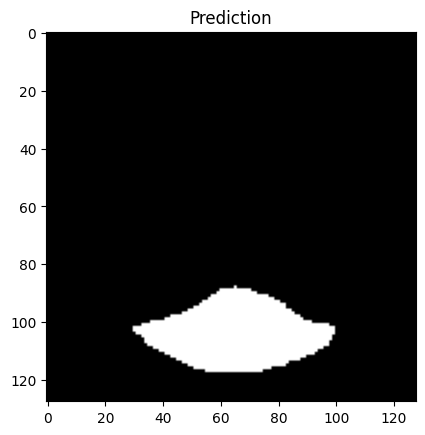

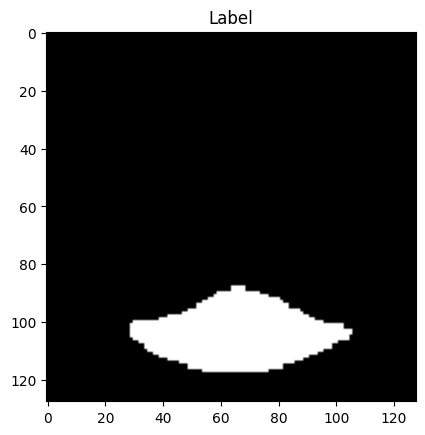

In [ ]:
import nibabel as nib
from torch.cuda.amp import autocast

sw_batch_size = 4
roi_size = (128, 128, 128)

with torch.no_grad(), autocast():
    test_patient = first(test_loader) #
    t_volume = test_patient['vol']
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    # Convert boolean array to integer array for prediction
    prediction_array = test_outputs[0, 1].detach().cpu().numpy().astype(np.uint8)

    # Convert original mask values to binary mask (0 or 1)
    label_array = (test_patient['seg'][0, 0].detach().cpu().numpy() > 0).astype(np.uint8)

    # Save the prediction and label as Nifti
    output_nifti_pred = nib.Nifti1Image(prediction_array, affine=np.eye(4))
    output_nifti_label = nib.Nifti1Image(label_array, affine=np.eye(4))

    nib.save(output_nifti_pred, 'UNet_patient2_prediction.nii.gz')
    nib.save(output_nifti_label, 'UNet_patient2_label.nii.gz')

    import matplotlib.pyplot as plt

    # Example visualization for prediction
    plt.imshow(prediction_array[:, :, 80], cmap='gray')
    plt.title('Prediction')
    plt.show()

    # Example visualization for label with 'binary' colormap
    plt.imshow(label_array[:, :, 80], cmap='gray')
    plt.title('Label')
    plt.show()


In [ ]:
import os
import nibabel as nib
import torch
import matplotlib.pyplot as plt

# Specify the path to your image
image_path = "/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan/TrainVolumes/1.nii.gz"

# Load the NIfTI image
image = nib.load(image_path)
image_data = image.get_fdata()

# Convert the NIfTI image data to PyTorch tensor
torch_image = torch.from_numpy(image_data)

# Exclude zero values (background pixels)
torch_image_nonzero = torch_image[torch_image != 0]

# Check if there are any non-zero values
if torch_image_nonzero.numel() == 0:
    print("No non-zero values found.")
    exit()

# Scale pixel values to the range [0, 1] (exclude zero values)
min_value = torch_image_nonzero.min()
max_value = torch_image_nonzero.max()
scaled_image = (torch_image_nonzero - min_value) / (max_value - min_value)

# Flatten the 3D image data to create 1D arrays
flattened_data_original = torch_image_nonzero.flatten().numpy()
flattened_data_scaled = scaled_image.flatten().numpy()

# Plot the histograms individually
plt.figure(figsize=(8, 6))

plt.hist(flattened_data_original, bins=700, alpha=0.7)
plt.title('')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(flattened_data_scaled, bins=700, alpha=0.7)
plt.title('')
plt.xlabel('Pixel Value (Scaled to [0, 1])')
plt.ylabel('Frequency')
plt.show()
